KEY INPUTS

In [18]:
config_name = 'model.cfg'
time_horizon = 1000
wanted_shot = '180634'

In [19]:
import h5py as h5
import matplotlib.pyplot as plt
import os
import configparser
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import sys
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from auton_survival.preprocessing import Scaler
import optuna
from sklearn.model_selection import ParameterGrid
#sys.path.append('/projects/EKOLEMEN/survival_tm/train_models/auton-survival')
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from sklearn.model_selection import ParameterGrid
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from auton_survival.models.dsm import DeepSurvivalMachines
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
from get_survival_from_shot import get_survival_from_shot, get_cakenn_survival_from_shot
import copy

LOAD MODEL AND ITS DATABASE

In [20]:
# READ CONFIG
config = configparser.ConfigParser()
config.read(config_name)
database_x_name = config['model']['database_x_name']
database_e_name = config['model']['database_e_name']
database_t_name = config['model']['database_t_name']
database_shots_list_name = config['model']['database_shots_list_name']
output_filename_base = config['model']['output_filename_base']

# LOAD DATABASE
with open(f'data/{database_x_name}.pkl', 'rb') as f:
    x = pickle.load(f)
with open(f'data/{database_e_name}.pkl', 'rb') as f:
    e = pickle.load(f)
with open(f'data/{database_t_name}.pkl', 'rb') as f:
    t = pickle.load(f)
with open(f'data/{database_shots_list_name}.pkl', 'rb') as f:
    shots_list = pickle.load(f)

# LOAD MODEL
with open(f'models/{output_filename_base}.pkl', 'rb') as f:
    model = pickle.load(f)[0][0]

RUN MODEL

In [21]:
survival_output = model.predict_survival(x, [time_horizon])

/home/hf8585/TMPredictor/survival_tm/auton-survival/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


PLOT SPECIFIC SHOT VALUES

Text(0.5, 1.0, 'Shot 180634')

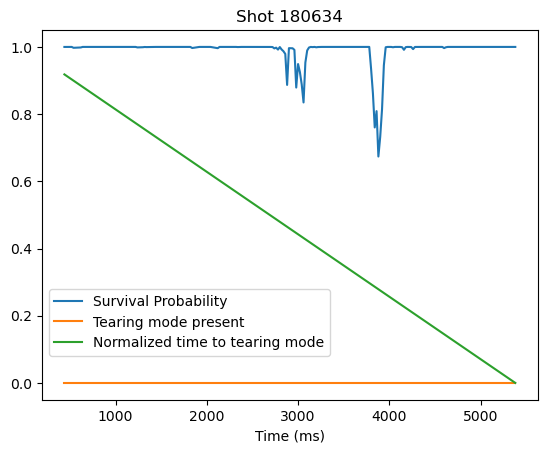

In [22]:
# FIND START AND END OF WANTED SHOT IN DATABASE
start_index = np.where(shots_list == wanted_shot)[0][0]
end_index = len(shots_list) - 1 - np.where(shots_list[::-1] == wanted_shot)[0][0]
x_shot = x[start_index:end_index]
t_shot = t[start_index:end_index][::-1]
survival_output_shot = survival_output[start_index:end_index]

plt.plot(t_shot, survival_output_shot, label='Survival Probability')
plt.plot(t_shot, e[start_index:end_index], label='Tearing mode present')
plt.plot(t_shot, 1-t_shot/t_shot.max(), label='Normalized time to tearing mode')
plt.xlabel('Time (ms)')
plt.legend(loc='lower left', bbox_to_anchor=(0, 0.1))
plt.title(f'Shot {wanted_shot}')